# MCMC Introduction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc.mcmc import analyse
from py21cmmc import mcmc

%load_ext autoreload
%autoreload 2

In this notebook we demonstrate how to do the simplest possible MCMC to fit just two astrophysical parameters to a series of coeval brightness temperature boxes without noise, and then visualise the results.

This tutorial will introduce the basic components of using ``py21cmmc`` for doing MCMC to fit parameters. For more advanced topics, see the relevant tutorials, guides or FAQs.

In [2]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## The Structure of MCMC

As a bit of a primer, we discuss some of the implementation structure for how likelihoods are actually evaluated in 21CMMC. Understanding this structure will help to identify any issues that may arise, construct useful likelihoods, utilise the various options that the built-in structures have, and eventually to create your own (see XXX for more details of how to do this).

The structure of an MCMC routine in 21CMMC is based on that offered by the ``cosmoHammer`` library, but with heavy modifications. This structure is based on a single master ``LikelihoodComputationChain`` (let's just call it the ``Chain``), which houses a number of what we'll call ``core``s and ``likelihood``s. These are instances of Python classes which can be named arbitrarily (and in principle do not need to be subclassed from any particular object), but follow a minimal API, which we'll outline shortly. In short, any ``Chain`` requires at _least_ one ``core``, and at least one ``likelihood``. Multiples of each are allowed and will work together seamlessly. 

Any MCMC should be run using the ``run_mcmc`` function in 21CMMC. While the MCMC can be run manually by setting up a ``Chain`` with its ``core``s and ``likelihood``s, there are various pitfalls and gotchas associated with this that usually make it easier just to use the in-built function. This function will take a list of ``core``s and ``likelihood``s, along with some specifications of how the MCMC is to proceed, set up a ``Chain``, run the MCMC sampling, and return the ``Chain`` object to you.

Thus, almost all of the flexibility of 21CMMC lies in the construction of the various ``core`` and ``likelihood`` modules.

### Core and Likelihood Modules

Let's briefly discuss these important ``core`` and ``likelihood`` modules -- the philosophy behind them, and what they can and can't do. We'll leave a discussion of how to go about implementing your own for another tutorial.

The basic idea behind ``core`` and ``likelihood`` modules is that the ``core``s are supposed to do the calculations to fill up what is called a ``context`` dictionary on every iteration of the MCMC. The ``likelihood``s then use the contents of this ``context`` to evaluate a likelihood (this ends up being the sum of the likelihood returned by each ``likelihood`` module). 

In practice, there is no hard-and-fast limit to the scope of the ``core`` or ``likelihood``: the ``core`` could evaluate the likelihood itself, store it in the ``context``, and the ``likelihood`` could merely access and return it. Likewise, the ``core`` could do nothing, and let the ``likelihood`` perform the entire calculation. 

For practical and philosophical reasons, however there are a few properties of each which dictate how _best_ to separate the work that each kind of module does:

1. All ``core`` modules constructively interfere. That is, they are invoked in sequence, and the output of one propagates as potential input to the next. The various quantities that are computed by the ``core``s are not over-written (unless specifically directed to), but are rather accumulated. 
2. Conversely, all ``likelihood`` modules are invoked after all of the ``core`` modules have been invoked. Each likelihood module is expected to have access to all information from the sequency of ``core``s, and is expected not to modify that information. The operation of each ``likelihood`` is thus in principle independent of each of the other ``likelihood``s. This implies that the total posterior is the sum of each of the likelihoods, which are considered statistically independent. 
3. Due to the first two points, we consider ``core``s as *constructive* and ``likelihood``s as *reductive*. That is, it is most useful to put calculations that _build_ data given a set of parameters in ``core``s, and operations that _reduce_ that data to some final form (eg. a power spectrum) in the ``likelihoods``. This is because a given dataset, produced by the accumulation of ``core``s, may yield a number of independent likelihoods, while these ``likelihood``s may be equally valid for a range of different data models (eg. inclusion or exclusion of various systematic effects). 
4. Point 3 implies that it is cleanest if all operations that explicitly require the model parameters occur in ``core``s. The reduction of data should not in general be model-dependent. In practice, the current parameters _are_ available in the ``likelihood``s, but we consider it cleaner if this can be separated.
5. In general, as both the ``core``s and ``likelihood``s are used to build a probabilistic _model_ which can be used to evaluate the likelihood of given _data_, both of their output should in principle be deterministic with respect to input parameters. Nevertheless, one may consider the process as a forward-model, and a forward-model is able to _produce_ mock data. Indeed, 21CMMC adds a framework to the base ``cosmoHammer`` for producing such mock data, which are inherently stochastic. A useful way to conceptualize the separation of ``core`` and ``likelihood`` is to ensure that all stochasticity can in principle be added in the ``core``, and that the ``likelihood`` should have no aspect of randomness in any of its calculations. The ``likelihood`` should reduce real/mock data in the same way that it reduces model data.

Given these considerations, the ``core`` modules that are implemented within ``21CMMC`` perform ``21cmFAST`` simulations and add these large datasets to the ``context``, while the various ``likelihoods`` will use this "raw" data and compress it down to a likelihood -- either by taking a power spectrum, global average or some other reduction. 

Some of the features of ``core``s as implemented in 21CMMC are the following. Each ``core``:
* has access to the entire ``Chain`` in which it is embedded (if it is indeed embedded), which enables sharing of information between ``core``s (and ensuring that they are consistent with one another, if applicable).
* has access to the names of the parameters which are currently being constrained.
* is enabled for equality testing with other ``core``s.
* has a special method (and runtime parameters) for storing arbitrary data in the ``Chain`` on a per-iteration basis (see the advanced MCMC FAQ for more info).
* has an optional method for converting a data model into a "mock" (i.e. incorporating a random component), which can be used to simulate mock data for consistency testing.

Some of the features of ``likelihood``s as implemented in 21CMMC are that each ``likelihood``:
* also has access to the ``Chain`` and parameter names, as well as equality testing, like the ``core``s.
* computes the likelihood in two steps: first reducing model data to a "final form", and then computing the likelihood from this form (eg. reducing a simulation cube to a 1D power spectrum, and then computing a $\chi^2$ likelihood on the power spectrum). This enables two things: (i) production and saving of reduced mock data, which can be used directly for consistency tests, and (ii) the ability to use _either_ raw data or reduced data as input to the likelihood.
* has methods for loading data and noise from files.
* has the ability to check that a list of ``required_cores`` are loaded in the ``Chain``.

## Running MCMC

Enough discussion, let's create our ``core`` and ``likelihood``. In this tutorial we use a single ``core`` -- one which evaluates the coeval brightness temperature field at an arbitrary selection of redshifts, and a single ``likelihood`` -- one which reduces the 3D field(s) into a 1D power spectrum/spectra and evaluates the likelihood based on a $\chi$-square fit to data.

In [3]:
core = mcmc.CoreCoevalModule( # All core modules are prefixed by Core* and end with *Module
    redshift = [7,8,9],          # Redshifts of the coeval fields produced.
    user_params = dict(       # Here we pass some user parameters. Also cosmo_params, astro_params and flag_options
        HII_DIM = 50,         # are available. These specify only the *base* parameters of the data, *not* the
        BOX_LEN = 125.0       # parameters that are fit by MCMC.
    ),
    regenerate=False          # Don't regenerate init_boxes or perturb_fields if they are already in cache.
) # For other available options, see the docstring.

# Now the likelihood...
datafiles = ["data/simple_mcmc_data_%s.npz"%z for z in core.redshift]

likelihood = mcmc.Likelihood1DPowerCoeval(  # All likelihood modules are prefixed by Likelihood*
    datafile = datafiles,                   # All likelihoods have this, which specifies where to write/read data
    noisefile= None,                        # All likelihoods have this, specifying where to find noise profiles.
    logk=False,                             # Should the power spectrum bins be log-spaced?
    min_k=0.1,                              # Minimum k to use for likelihood
    max_k=1.0,                              # Maximum ""
    simulate = True,                        # Simulate the data, instead of reading it in.
                                            # will be performed.
) # For other available options, see the docstring

Now we have all we need to start running the MCMC. The most important part of the call to ``run_mcmc`` is the specification of ``params``, which specifies which are the parameters *to be fit*. This is passed as a dictionary, where the keys are the parameter names, and *must* come from either ``cosmo_params`` or ``astro_params``, and be of ``float`` type. The values of the dictionary are length-4 lists: ``(guess, min, max, width)``. The first specifies where the best guess of the true value lies, and the initial walkers will be chosen around here. The ``min/max`` arguments provide upper and lower limits on the parameter, outside of which the likelihood will be ``-infinity``. The ``width`` affects the initial distribution of walkers around the best-guess (it does *not* influence any kind of "prior"). 

Finally, the ``model_name`` merely affects the file name of the output chain data, along with the ``datadir`` argument.

In [5]:
model_name = "SimpleTest"

chain = mcmc.run_mcmc(
    core, likelihood,        # Use lists if multiple cores/likelihoods required. These will be eval'd in order.
    datadir='data',          # Directory for all outputs
    model_name=model_name,   # Filename of main chain output
    params=dict(             # Parameter dict as described above.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 4, 6, 0.1],
    ), 
    walkersRatio=3,         # The number of walkers will be walkersRatio*nparams
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=150,    # Number of iterations to sample, per walker.
    threadCount=6,           # Number of processes to use in MCMC (best as a factor of walkersRatio)
    continue_sampling=False  # Whether to contine sampling from previous run *up to* sampleIterations.
)

INFO:cosmoHammer:Using CosmoHammer 0.6.1
INFO:cosmoHammer:Using emcee 2.2.1
INFO:cosmoHammer:all burnin iterations already completed
INFO:cosmoHammer:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30.   4.7]
  Burnin iterations: 0
  Samples iterations: 150
  Walkers ratio: 3
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7fb0b15f5ef0>
likelihoodComputationChain: 
Core Modules: 
  CoreCoevalModule
Likelihood Modules: 
  Likelihood1DPowerCoeval

INFO:cosmoHammer:start sampling after burn in
INFO:cosmoHammer:Iteration finished:10
INFO:cosmoHammer:Iteration finished:20
INFO:cosmoHammer:Iteration finished:30
INFO:cosmoHammer:Iteration finished:40
INFO:cosmoHammer:Iteration finished:50
INFO:cosmoHammer:Iteration finished:60
INFO:cosmoHammer:Iteration finished:70
INFO:cosmoHammer:I

## Analysis

### Accessing chain data

The full chain data, as well as any stored data (as "blobs") is available within the chain as the ``samples`` attribute.
If access to this "chain" object is lost (eg. the MCMC was run via CLI and is finished), an exact replica of the store object can be read in from file. Unified access is provided through the ``get_samples`` function in the ``analyse`` module. Thus all these are equivalent:

In [6]:
samples1 = chain.samples

samples2 = analyse.get_samples(chain)

samples3 = analyse.get_samples("data/%s"%model_name)

# Equivalent:
# samples = analyse.get_samples("data/%s"%model_name)

In [7]:
print(np.all(samples1.accepted == samples2.accepted))
print(np.all(samples1.accepted == samples3.accepted))

True
True


Do note that while the first two methods return exactly the same object, occupying the same memory:

In [8]:
samples1 is samples2

True

this is not true when reading in the samples from file:

In [9]:
print(samples1 is samples3)
del samples3; samples=samples1 # Remove unnecessary memory, and rename to samples

False


Several methods are defined on the sample object (which has type ``HDFStore``), to ease interactions. For example, one can access the various dimensions of the chain:

In [10]:
niter = samples.size
nwalkers, nparams = samples.shape

We can also check what the parameter names of the run were, and their initial "guess" (this is the first value passed to the "parameters" dictionary in ``run_mcmc``:

In [11]:
print(samples.param_names)
print([samples.param_guess[k] for k in samples.param_names])

('HII_EFF_FACTOR', 'ION_Tvir_MIN')
[array([30.]), array([4.7])]


Or one can view how many iterations were accepted for each walker:

In [12]:
samples.accepted, np.mean(samples.accepted/niter)

(array([102, 100, 118, 107,  97, 103]), 0.6966666666666667)

We can also  see what extra data we saved along the way by getting the blob names (see below for more details on this):

In [13]:
samples.blob_names

('k_z7', 'delta_z7', 'k_z8', 'delta_z8', 'k_z9', 'delta_z9')

Finally, we can get the actual chain data, using ``get_chain`` and friends. However, this is best done dynamically, as the ``samples`` object itself does *not* hold the chain in memory, rather transparently read it from file when accessed. 

### Trace Plot

Often, for diagnostic purposes, the most useful plot to start with is the trace plot. This enables quick diagnosis of burnin time and walkers that haven't converged. The function in ``py21cmmc`` by default plots the log probability along with the various parameters that were fit. It also supports setting a starting iteration, and a thinning amount. 

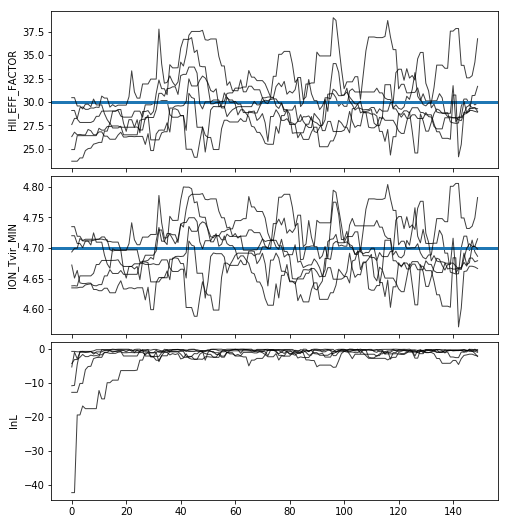

In [14]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

### Corner Plot

One of the most useful plots to come out of an MCMC analysis is the "corner" plot, which shows the correlation of each parameter with every other parameter. The function in ``py21cmmc`` will by default also show the original "guess" for each parameter as a blue line, and also show the log-likelihood as a psuedo-"parameter", though this can be turned off.

In [15]:
samples.param_guess

array([(30., 4.7)],
      dtype=[('HII_EFF_FACTOR', '<f8'), ('ION_Tvir_MIN', '<f8')])

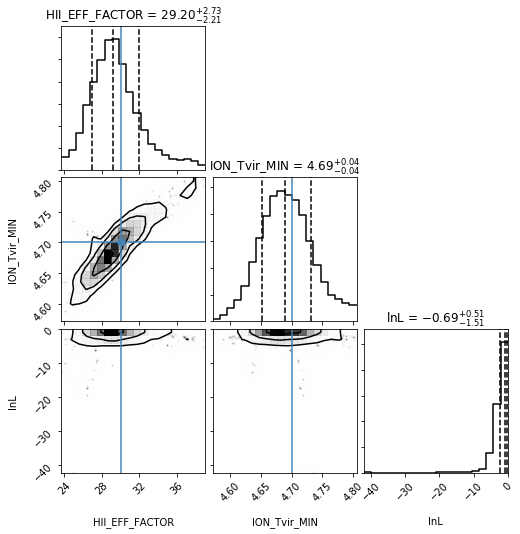

In [16]:
analyse.corner_plot(samples);

### Model Comparison Plot

Another plot of interest is a "model comparison" plot -- i.e. comparing the range of outputted models to the data itself. These will differ significantly depending on the kind of data produced by the likelihood function, and thus they depend also on the actual data used. We thus do not provide a general function for plotting this. We do however show how one might go about this task in the function below.

First, however, we show how one might interact with the data and saved models/blobs.

To extract all blob data from the samples:

In [17]:
blobs = samples.get_blobs()

For simplicity, let's extract each kind of blob from the blob structured array:

In [18]:
k = blobs['k_z7']
model_power = blobs['delta_z7'], blobs['delta_z8'], blobs['delta_z9']

print(k.shape, model_power[0].shape)
nk = k.shape[-1]

(150, 6, 22) (150, 6, 22)


Here we notice that ``k`` should be the same on each iteration, so we take just the first:

In [19]:
print(np.all(k[0] == k[1]))
k = k[0]

True


Finally, we also want to access the *data* to which the models have been compared. Since we have access to the original ``likelihood`` object, we can easily pull this from it. However, we equivalently could have read it in from file (this file is *not* always present, only if ``datafile`` is present in the likelihood constructor):

In [20]:
p_data = np.array([d['delta'] for d in likelihood.data])
k_data = np.array([d['k'] for d in likelihood.data])

# Equivalent
# data = np.genfromtxt("simple_mcmc_data.txt")
# k_data = data[:,0]
# p_data = data[:,1:]

Now, let's define a function which will plot our model comparison:

In [21]:
def model_compare_plot(samples, p_data, k_data, thin=1, start_iter=0):
    chain = samples.get_chain(thin=thin, discard=start_iter, flat=True)
    blobs = samples.get_blobs(thin=thin, discard=start_iter, flat=True)
    
    k = blobs['k_z7'][0]
    model_power = [blobs[name] for name in samples.blob_names if name.startswith("delta_")]
    
    print(k.shape)
    
    nz = len(model_power)
    nk = k.shape[-1]
    
    fig, ax = plt.subplots(1, nz, sharex=True, sharey=True, figsize=(6*nz, 4.5), 
                          subplot_kw={"xscale":'log', "yscale":'log'}, gridspec_kw={"hspace":0.05, 'wspace':0.05},
                          squeeze=False)

    for i in range(nz):
        this_power = model_power[i]
        this_data = p_data[i]

        label="models"

        for pp in this_power:
            ax[0,i].plot(k, pp, color='k', alpha=0.2, label=label, zorder=1)
            if label:
                label=None

        mean = np.mean(this_power, axis=0)
        std = np.std(this_power, axis=0)
        md = np.median(this_power, axis=0)

        ax[0,i].fill_between(k, mean - std, mean+std, color="C0", alpha=0.6)
        ax[0,i].plot(k, md, color="C0", label="median model")

        ax[0,i].errorbar(k_data, this_data, yerr = (0.15*this_data), color="C1", 
                     label="data", ls="None", markersize=5, marker='o')

        ax[0,i].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
        ax[0,i].text(0.1, 0.86, "z=%s"%core.redshift[i], transform=ax[0,i].transAxes, fontsize=15, fontweight='bold')

    ax[0,0].legend(fontsize=12)
    #plt.ylim((3.1e2, 3.5e3))


    ax[0,0].set_ylabel("$\Delta^2_{21}$", fontsize=15)

#plt.savefig(join(direc, modelname+"_power_spectrum_plot.pdf"))

(22,)


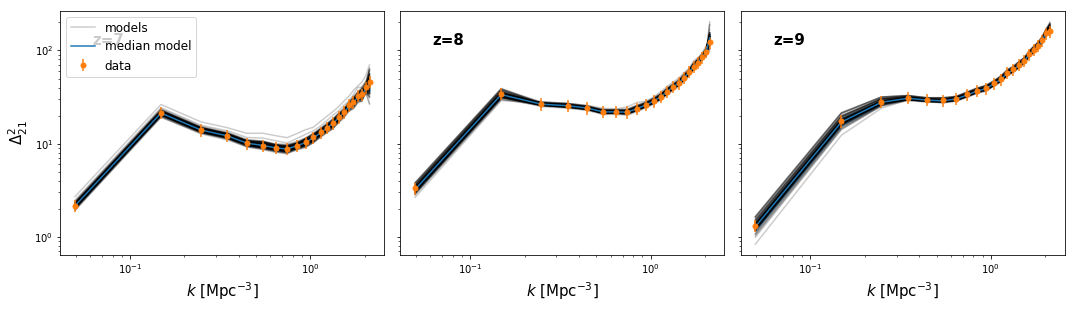

In [22]:
model_compare_plot(samples, p_data, k_data[0], thin=10)